## This notebook should permit you to fit your experimental curve with pseudo-voigt peaks. Your curve should be baseline-corrected.##
This procedure allows you to manually determine reasonable initial parameters to pass on to scipy optimize module.

**Instructions:** 
1. Left-click on the graph to add one pseudo-voigt profile at a time.
    -  Once the profile added, you can modify its width by scrolling the mouse wheel.
2. Repeat the procedure as many times as needed to account for all the peaks.
- Right-clicking any time, will draw the sum of all the present profiles you added up to that moment.
- Left clicking on the top of existing peak erases it.

In [1]:
import os
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.artist import ArtistInspector
from cycler import cycler
from copy import copy
from itertools import chain
from scipy.optimize import curve_fit
from IPython.display import display
from ipywidgets import widgets

plt.style.use('bmh')

In [2]:
gaussian_laurentzian_ratio = 0.5
def pV(x, h=30, x0=0, w=10, factor=gaussian_laurentzian_ratio):
    '''Manualy created pseudo-Voigt profile
    Parameters:
    ------------
    x: Independent variable
    h: height
    x0: The position of the peak on the x-axis
    w: FWHM
    factor: the ratio of Gauss vs Lorentz in the peak
    Returns:
    y-array of the same shape as the input x-array
    '''

    def Gauss(x, w):
        return((2/w) * np.sqrt(np.log(2)/np.pi) * np.exp(
                -(4*np.log(2)/w**2) * (x - x0)**2))

    def Lorentz(x, w):
        return((1/np.pi)*(w/2) / (
                (x - x0)**2 + (w/2)**2))

    intensity = h * np.pi * (w/2) / (
                    1 + factor * (np.sqrt(np.pi*np.log(2)) - 1))

    return(intensity * (factor * Gauss(x, w)
                        + (1-factor) * Lorentz(x, w)))


def fitting_function(x, *params):
    '''
    The function giving the sum of the pseudo-Voigt peaks.
    Parameters:
    *params: is a list of parameters. Its length is = 4 * "number of peaks",
    where 4 is the number of parameters in the "pV" function.
    Look in the docstring of pV function for more info on theese.
    '''
    result = np.zeros_like(x, dtype=np.float)
    for i in range(0, len(params), 4):
        result += pV(x, *params[i:i+4])  # h, x0, w, r)
    return result

In [3]:
# Creating some data...
# You should replace this whole cell with loading your own data
# You should provide x and y as numpy arrays of shape ("length of data", )
# For example: >>> x, y = np.loadtxt("your_file_containing_data.txt")

dummy_params = [51, 200, 85, 0.7,
                10, 272, 37, 0.8,
                2.7, 317, 39, 0.52,
                3.9, 471, 62, 0.25]

dummy_x = np.arange(0, 584, 1.34)
dummy_y = fitting_function(dummy_x, *dummy_params)
dummy_y += np.random.random(len(dummy_x))*np.mean(dummy_y)/5


x = dummy_x
y = dummy_y/500000

In [4]:
# Setting some sensible values to be used afterwards,
# for example the point size (normally, no need to change theese):
def set_size(variable, rapport=70):
    return (variable.max() - variable.min())/rapport


x_size = set_size(x)
y_size = 2*set_size(y)
# Setting up the plot:
fig, ax = plt.subplots(figsize=(9, 8))
ax.scatter(x, y, marker='o', c='k', s=64, alpha=0.5, edgecolors='none')
plt.show()
# %%

# this sets up the color palette to be used for plotting lines:
plt.rcParams["axes.prop_cycle"] =\
    cycler('color',
           ['#332288', '#CC6677', '#DDCC77', '#117733', '#88CCEE', '#AA4499',
            '#44AA99', '#999933', '#882255', '#661100', '#6699CC', '#AA4466'])
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Initiating variables to which we will atribute peak caractéristics:
pic = {}
pic['line'] = []  # List containing matplotlib.Line2D object for each peak
pic['h'] = []  # List that will contain heights of each peak
pic['x0'] = []  # List that will contain central positions of each peak
pic['w'] = []  # List containing widths
pic['fill'] = []

# Iterator used normally for counting right clicks
# (each right click launches the plot of the cumulative curbe)
it = 0

# List of cumulated graphs
# (used later for updating while removing previous one)
sum_peak = []

peaks_present = 0
cid3 = []
scroll_count = 0  # counter to store the cumulative values of scrolling
artists = []
clicked_indice = -1



output = widgets.Output()
@output.capture()
def onclick(event):
    global it, peaks_present, scroll_count, clicked_indice
    global x_size, y_size, x, block
    if event.inaxes == ax:  # if you click inside the plot
        if event.button == 1:  # left click
            # Create list of all elipses and check if the click was inside:
            click_in_artist = [artist.contains(event)[0] for artist in artists]
            if not any(click_in_artist):  # if click was not on any elipsis
                peaks_present += 1
                one_elipsis = ax.add_artist(
                                Ellipse((event.xdata, event.ydata),
                                        x_size, y_size, alpha=0.5,
                                        gid=str(peaks_present)))
                artists.append(one_elipsis)
                h = event.ydata
                x0 = event.xdata
                yy = pV(x=x, h=h, x0=x0, w=x_size)
                pic['line'].append(ax.plot(x, yy, alpha=0.75, lw=2.5,
                                   picker=5))
                # ax.set_ylim(auto=True)
                pic['h'].append(h)
                pic['x0'].append(x0)
                pic['w'].append(x_size)
# ax.fill_between(x, yy.min(), yy, alpha=0.3, color=cycle[peaks_present])
                fig.canvas.draw_idle()

            elif any(click_in_artist):  # if the click was on one of the elipses
                clicked_indice = click_in_artist.index(True)
                artists[clicked_indice].remove()
                artists.pop(clicked_indice)
                ax.lines.remove(pic['line'][clicked_indice][0])
                pic['line'].pop(clicked_indice)
                pic['x0'].pop(clicked_indice)
                pic['h'].pop(clicked_indice)
                pic['w'].pop(clicked_indice)
                fig.canvas.draw_idle()
                peaks_present -= 1

        elif event.button == 3 and not event.step:
            # On my laptop middle click and right click have the same values
            if it > 0:  # Checks if there is already a cumulated graph plotted
                # remove the last cumulated graph from the figure:
                ax.lines.remove(sum_peak[-1][0])
                sum_peak.pop()
            # Sum all the y values from all the peaks:
            sumy = np.sum(np.asarray(
                    [pic['line'][i][0].get_ydata() for i in range(peaks_present)]),
                    axis=0)
            # Added this condition for the case where you removed all peaks,
            # but the cumulated graph is left
            # then right-clicking need to remove that one as well:
            if sumy.shape == x.shape:
                # plot the cumulated graph:
                sum_peak.append(ax.plot(x, sumy, '--', color='lightgreen',
                                        lw=3, alpha=0.6))
                it+=1 # One cumulated graph added
            else:
                # if you right clicked on the graph with no peaks,
                # you removed the cumulated graph as well
                it-=1
            fig.canvas.draw_idle()

        if event.step != 0:
            if peaks_present:
                # -1 means that scrolling will only affect the last plotted peak
                peak_identifier = -1
                '''(this may change in the future so to permit the user
                to modify whatewer peak's widht he wishes to adjust)
                This however turns out to be a bit too difficult to acheive.
                For now, I'll settle with this version, where,
                if you want to readjust some previously placed peak,
                you need in fact to repace it with a new one
                (you can first add the new one on the position that you think
                 is better, adjust it's width, and then remove the one
                 you didn't like by clicking on it's top)'''

                # This adjust the "speed" of width change with scrolling:
                scroll_count += x_size*event.step/15

                if scroll_count > -x_size+0.01:
                    w2 = x_size + scroll_count
                else:
                    w2 = 0.01
                    # This doesn't allow you to sroll to negative values
                    # (basic width is x_size)aliased_name
                    scroll_count = -x_size+0.01

                center2 = pic['x0'][peak_identifier]
                h2 = pic['h'][peak_identifier]
                pic['w'][peak_identifier] = w2
                yy = pV(x=x, x0=center2, h=h2, w=w2)
                active_line = pic['line'][peak_identifier][0]
                # This updates the values on the peak identified by
                # "peak_identifier" (last peak if = -1).
                active_line.set_ydata(yy)
                ax.draw_artist(active_line)
#                if peak_identifier > -1:
#                    cycle_indice = peak_identifier
#                else:
#                    cycle_indice = peaks_present
#                pic['fill'].append(ax.fill_between(x, 0, yy, alpha=0.3, color=cycle[cycle_indice]))
                fig.canvas.draw_idle()

        if event.button != 1 and event.dblclick:
            block = True
            fig.canvas.mpl_disconnect(cid)
            fig.canvas.mpl_disconnect(cid2)
            plt.close()
            return        
ax.set_title('Left-click to add/remove peaks, Scroll to adjust width, Right-click to draw the sum') 
ax.set_ylim(bottom=-y_size, top=y_size*50)
cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid2 = fig.canvas.mpl_connect('scroll_event', onclick)#scroll)

display(output)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Output()

In [6]:
# # recovering the y values of each peak (not really useful):
# manualfit_components = [copy(line[0].get_data()[1]) for line in pic['line']]

# creating the list of initial parameters from your manual input:
# (as a list of lists)

manualfit_components_params = copy(list(map(list, zip(
                            pic['h'], pic['x0'], pic['w'], [gaussian_laurentzian_ratio]*peaks_present
                            ))))
# to transform the list of lists into one single list:
manualfit_components_params = list(chain(*manualfit_components_params))

# the sum of manually created peaks:
try:
    manualfit = sum_peak[0][0].get_data()[1]
except IndexError:
    print("It seems you have no peaks to begin with")

It seems you have no peaks to begin with


In [45]:
# Setting the bounds based on your input
# (you can play with this part depending on your data)

# set the initial bounds as infinities:
upper_bounds = np.ones(len(manualfit_components_params))*np.inf
lower_bounds = np.ones(len(manualfit_components_params))*(-np.inf)

# setting reasonable bounds for the peak amplitude
# as a portion to your initial manual estimate
upper_bounds[0::4] = [A*1.32 for A in manualfit_components_params[0::4]]
lower_bounds[0::4] = [A*0.75 for A in manualfit_components_params[0::4]]

# setting reasonable bounds for the peak position
# as a shift in regard to your initial manual position
upper_bounds[1::4] = \
    [shift + 2*x_size for shift in manualfit_components_params[1::4]]
lower_bounds[1::4] = \
    [shift - 2*x_size for shift in manualfit_components_params[1::4]]

# setting the bounds for the widths
upper_bounds[2::4] = \
    [width*10 for width in manualfit_components_params[2::4]]
lower_bounds[2::4] = \
    [width*0.5 for width in manualfit_components_params[2::4]]


# setting the bounds for the Gauss/Lorentz ratio
upper_bounds[3::4] = 1
lower_bounds[3::4] = 0


bounds = (lower_bounds, upper_bounds)

<IPython.core.display.Javascript object>


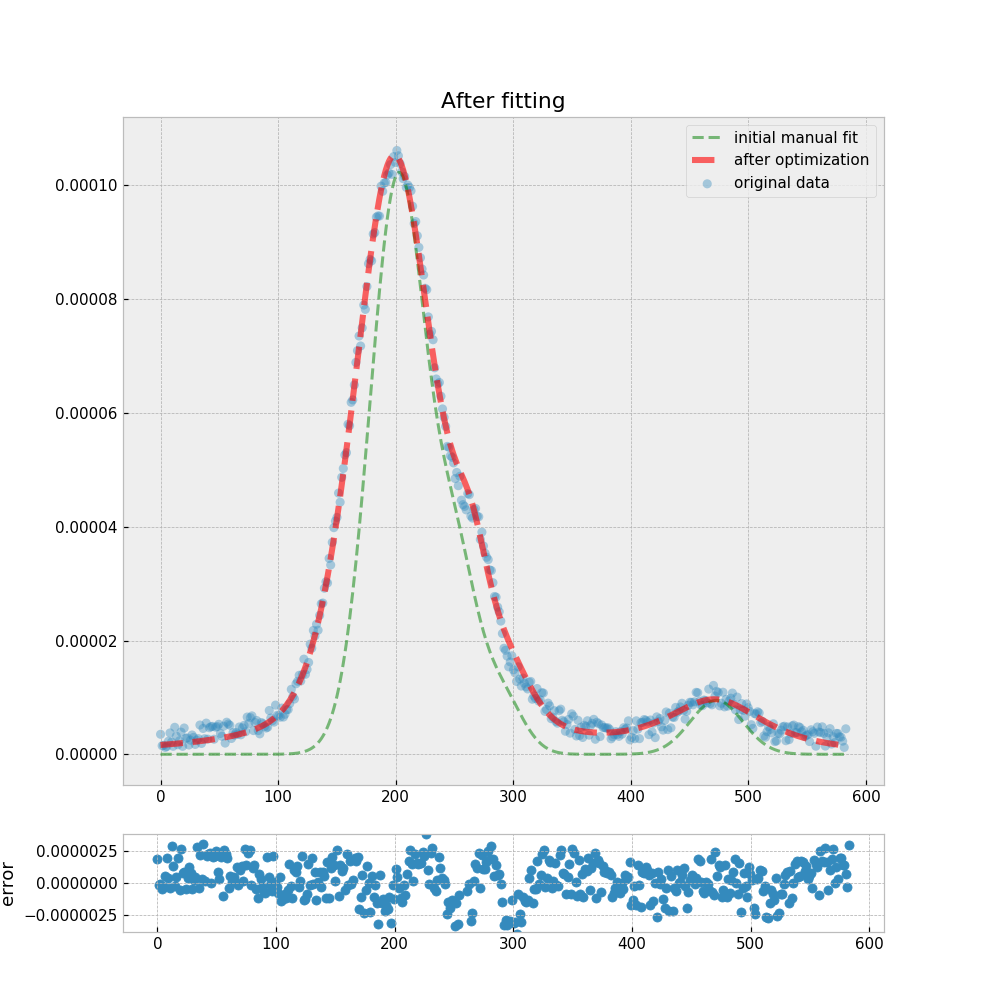

In [49]:
# The curve-fitting part:
fitted_params, b = curve_fit(fitting_function, x, y,
                             p0=manualfit_components_params, absolute_sigma=False, bounds=bounds)

y_fitted = fitting_function(x, *fitted_params)

figg, axx, = plt.subplots(figsize=(9,9))
figg.subplots_adjust(bottom=0.2)
errax = figg.add_axes([0.125, 0.05, 0.775, 0.1])
errax.set_facecolor('w')

axx.plot(x, manualfit,
         '--g', alpha=0.5, label='initial manual fit')

axx.scatter(x, y, alpha=0.4, edgecolor='none', label='original data')

axx.plot(x, y_fitted,
         '--r', lw=4, alpha=0.6, label='after optimization')

axx.legend()

diff_fit_y = y-y_fitted
errax.scatter(x, diff_fit_y)
errax.set_ylim(-np.max(diff_fit_y), np.max(diff_fit_y))
errax.set_ylabel('error')
axx.set_title('After fitting')
plt.show(block=False)

<IPython.core.display.Javascript object>


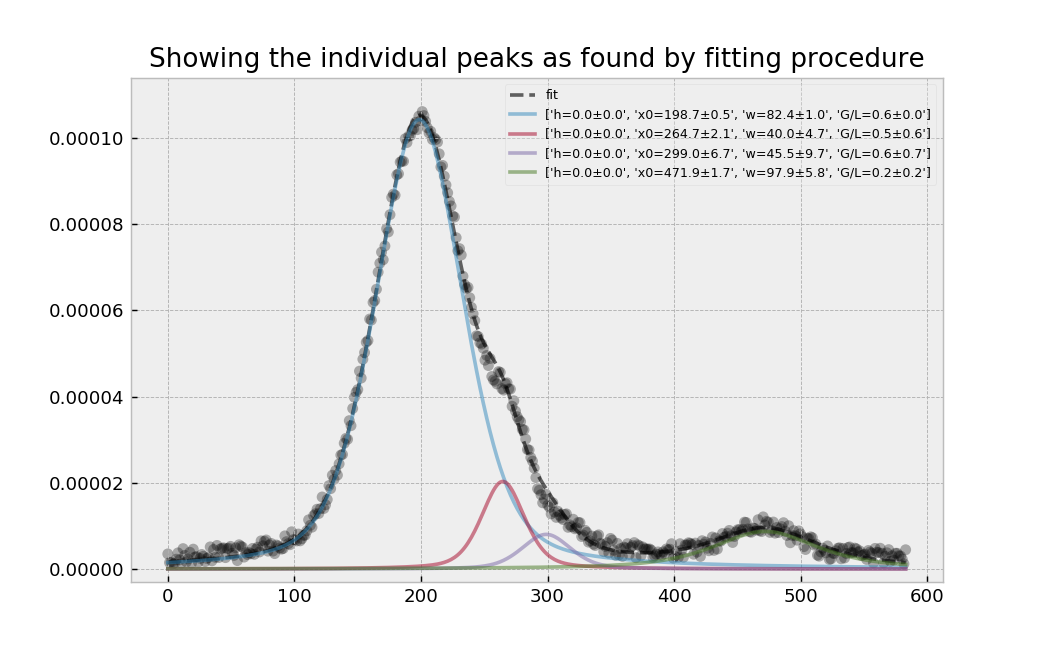

                             Your initial guess      After fitting

Peak 0|   Height              :      0.00     ->       0.00 ± 0.00
Peak 0|   Center              :    202.62     ->     198.73 ± 0.52
Peak 0|   FWMH                :     57.73     ->      82.40 ± 1.00
Peak 0|   Ratio Lorenz/Gauss  :      1.00     ->       0.55 ± 0.02
Peak 1|   Height              :      0.00     ->       0.00 ± 0.00
Peak 1|   Center              :    252.26     ->     264.67 ± 2.11
Peak 1|   FWMH                :     41.08     ->      40.04 ± 4.69
Peak 1|   Ratio Lorenz/Gauss  :      1.00     ->       0.52 ± 0.61
Peak 2|   Height              :      0.00     ->       0.00 ± 0.00
Peak 2|   Center              :    288.11     ->     298.96 ± 6.72
Peak 2|   FWMH                :     44.41     ->      45.53 ± 9.69
Peak 2|   Ratio Lorenz/Gauss  :      1.00     ->       0.56 ± 0.69
Peak 3|   Height              :      0.00     ->       0.00 ± 0.00
Peak 3|   Center              :    472.89     ->     471.91 ±

In [53]:

fitting_err = np.sqrt(np.diag(b))
plt.figure(figsize=(8, 5), dpi=120)
plt.scatter(x, y, lw=4, c='k', alpha=0.3, edgecolor='none')
plt.plot(x, fitting_function(x, *fitted_params),
         '--k', lw=2, alpha=0.6, label='fit')
par_nam = ['h', 'x0', 'w', 'G/L']
# plt.plot(manualfit, '--y', lw=3, alpha=0.6)
for i in range(peaks_present):
    fit_res = list(zip(par_nam, fitted_params[i*4:i*4+4],
                       fitting_err[i*4:i*4+4]))
    label = [f"{P}={v:.1f}\U000000B1{e:.1f}" for P, v, e in fit_res]
    plt.plot(x, pV(x, *fitted_params[i*4:i*4+4]), alpha=0.5, label=label)
plt.ylim(bottom=-y_size, top=y_size*38)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize='x-small', fancybox=True, framealpha=0.3)
plt.title('Showing the individual peaks as found by fitting procedure')
plt.show(block=False)
parametar_names = ['Height', 'Center', 'FWMH', 'Ratio Lorenz/Gauss']
print(f"{'Your initial guess':>47s}{'After fitting':>19s}\n")
for i in range(len(fitted_params)):
    print(f"Peak {i//4}|   {parametar_names[i%4]:<20s}: "
          f" {manualfit_components_params[i]:8.2f}     ->    "
          f" {fitted_params[i]:6.2f} \U000000B1 {fitting_err[i]:4.2f}")


In [ ]:
plt.close('all')